# Stochatic Optimal Growth

In [61]:
import tensorflow as tf
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import datetime
from typing import Tuple
class Vector: pass

37.98925353815225
(200, 1)
(200, 1) (200, 1)


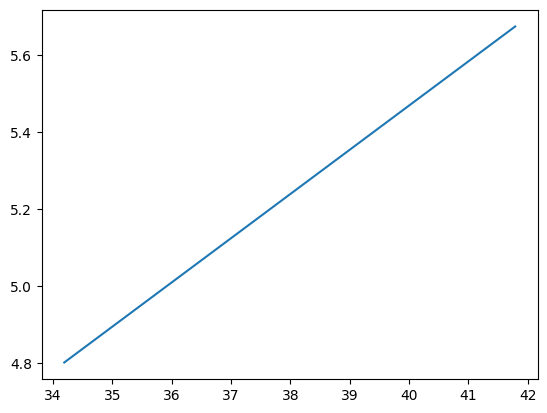

In [62]:
# Model parameters
β = 0.99
α = 0.36
δ = 0.025
σ = 2.0
Kss = ((1/β-1+δ)/α)**(1/(α-1))
print(Kss)
xmin=Kss*0.9
xmax=Kss*1.1

σ_z = 0.01
ρ_z = 0.9
σ_e_z = σ_z/(1-ρ_z**2)**0.5

min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
layers = [
    tf.keras.layers.Normalization(axis=-1, input_dim=2, mean=0, variance=1, invert=False),
    tf.keras.layers.Dense(32, activation='leaky_relu',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='leaky_relu',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

def model(k:Vector,z:Vector)->Tuple[Vector]:
    s = tf.concat([i[:,None] for i in [k,z]], axis=1) # equivalent to np.column_stack
    sh = perceptron(s)
    return sh

λ=1
xvec = np.linspace(xmin,xmax,200,dtype='float32').reshape(-1,1)
zvec = np.linspace(-2*σ_e_z,2*σ_e_z,200,dtype='float32').reshape(-1,1)
print(xvec.shape)
print(xvec.shape, model(xvec,zvec).shape)
plt.plot(xvec, model(xvec,zvec), label = 'c(x)')

In [87]:
def residuals(k:Vector, z:Vector, ez:Vector):
    #print(k,z)
    c=model(k,tf.exp(z))
    kp=tf.exp(z)*k**α+(1-δ)*k-c
    zp = z*ρ_z + ez
    cp=model(kp,tf.exp(zp))
    #print(k,z,kp,zp,cp)
    euler = c**(-σ)-β*cp**(-σ)*(tf.exp(zp)*α*kp**(α-1)+1-δ)
    budget = tf.exp(z)*k**α+(1-δ)*k-c
    R = min_FB(budget,euler)
    return R

#print(residuals(xvec));

def J(n):
    z = tf.random.normal(shape=(n,1), stddev=σ_e_z)
    k = tf.random.uniform(shape=(n,1),minval=xmin,maxval=xmax)
    ez1 = tf.random.normal(shape=(n,1), stddev=σ_z)
    ez2 = tf.random.normal(shape=(n,1), stddev=σ_z)
    #print(z,k,ez1,ez2)
    R_e1 = residuals(k,z,ez1)
    R_e2 = residuals(k,z,ez2)
    R_squared = R_e1*R_e2
    return tf.reduce_mean(R_squared)

n = 10000
v = J(n)
v.numpy()

3.3453587e-09

In [88]:
θ = perceptron.trainable_variables
print(str(θ)[:1000])

[<tf.Variable 'dense_21/kernel:0' shape=(2, 32) dtype=float32, numpy=
array([[-0.13725115,  0.09573043, -0.16510913,  0.2052654 , -0.22548313,
        -0.16733934,  0.06770185,  0.04289444,  0.09608161,  0.12445315,
         0.29725766,  0.28790653,  0.07459211, -0.375621  ,  0.37870112,
         0.41365436,  0.05870144,  0.32642475, -0.088231  ,  0.11066737,
        -0.02118245,  0.3668401 ,  0.1129686 ,  0.2999969 ,  0.07717935,
         0.35248002, -0.11301993, -0.414704  ,  0.32609907,  0.03981882,
        -0.16277452,  0.16804986],
       [-0.27560562, -0.45449027,  0.2723439 ,  0.12459122, -0.10556421,
        -0.42587608,  0.21885686,  0.06183518,  0.16954552,  0.04238115,
         0.09130654, -0.3789167 ,  0.19253024, -0.07587414, -0.13375157,
        -0.00096663,  0.14261015,  0.16321668,  0.2570063 ,  0.2557646 ,
        -0.49494419, -0.07733541,  0.01904636, -0.20242521, -0.4167692 ,
        -0.21221766,  0.01572072,  0.11832101,  0.08765484, -0.20641497,
         0.17419276

In [89]:
from tensorflow.keras.optimizers import Adam, SGD
variables = perceptron.trainable_variables
optimizer = SGD()
optimizer.lr.assign(0.000001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-06>

In [90]:
@tf.function
def training_step():
    
    with tf.GradientTape() as tape:
        xx = J(n)
        
    grads = tape.gradient(xx,θ)
    optimizer.apply_gradients(zip(grads,θ))
    return xx

def train_me(K):
    vals=[]
    for k in tqdm(tf.range(K)):
        val=training_step()
        vals.append(val.numpy())
    return vals

In [91]:
results = train_me(500)

100%|███████████████████████████████████████████████████████| 500/500 [00:14<00:00, 35.38it/s]


/var/folders/xt/r947d5fd2yz1_fkptq29sn8r0000gn/T/ipykernel_7537/3593405677.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(results))


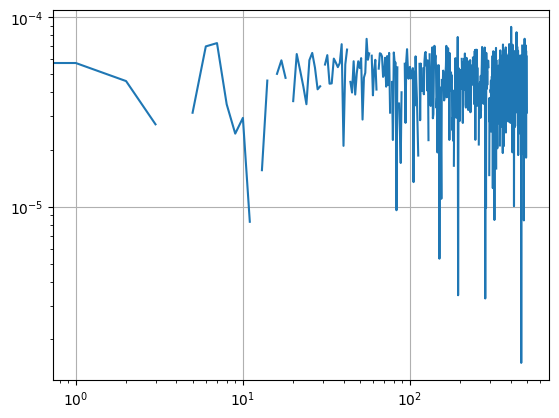

In [92]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

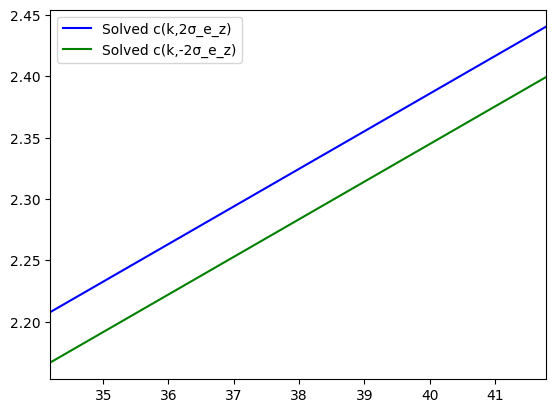

In [96]:
plt.plot(xvec,model(xvec, zvec*0+2*σ_e_z),label='Solved c(k,2σ_e_z)',c='b')
plt.plot(xvec,model(xvec, zvec*0-2*σ_e_z),label='Solved c(k,-2σ_e_z)',c='g')
plt.legend()
plt.xlim([xmin,xmax])
plt.show()

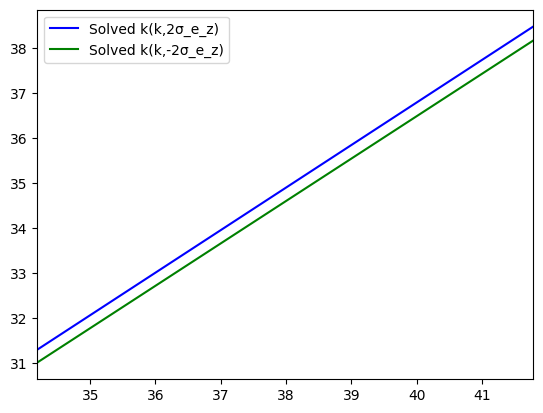

In [95]:
plt.plot(xvec,(zvec*0+2*σ_e_z)*xvec**α+(1-δ)*xvec - model(xvec, zvec*0+2*σ_e_z),label='Solved k(k,2σ_e_z)',c='b')
plt.plot(xvec,(zvec*0-2*σ_e_z)*xvec**α+(1-δ)*xvec - model(xvec, zvec*0-2*σ_e_z),label='Solved k(k,-2σ_e_z)',c='g')
plt.legend()
plt.xlim([xmin,xmax])
plt.show()